In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import os
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image 
import matplotlib.pyplot as plt

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

## Loading Data and Splitting into Test And Val

In [ ]:
!mkdir trainDir
!mkdir valDir

The dataset is split into 80% train and 20% validation - with equal distribution between classes. 

In [ ]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/'
for i in os.listdir(path):
    for j in os.listdir(path+i):
        os.system("mkdir /kaggle/working/trainDir/"+j)
        os.system("mkdir /kaggle/working/valDir/"+j)
        count = 0
        for k in os.listdir(path+i+"/"+j):
            count+=1
            if count<=4000:
                currDir="trainDir"
            else:
                currDir="valDir"
            os.system("cp "+path+i+"/"+j+"/"+k+" /kaggle/working/"+currDir+"/"+j+"/"+k)

In [ ]:
# loading images
imageDatasetTrain = datasets.ImageFolder(
    "/kaggle/working/trainDir",
    transform = transforms.Compose([
              transforms.Resize(227), #resizing images to 227x227 
              transforms.ToTensor()])
)
imageDatasetVal = datasets.ImageFolder(
    "/kaggle/working/valDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.ToTensor()])
)
# imageDataset = datasets.ImageFolder(
#     "/kaggle/working/imgData",
#     transform = transforms.Compose([
#               transforms.Resize(227),
#               transforms.ToTensor()]))
TRAIN = torch.utils.data.DataLoader(imageDatasetTrain, batch_size=8)
VAL = torch.utils.data.DataLoader(imageDatasetVal, batch_size=8)

In [ ]:
imageDatasetTrain.classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

There are 5 classes in the dataset, 3 for lung and 2 for colon.

## Visualizing Data and Preprocessing

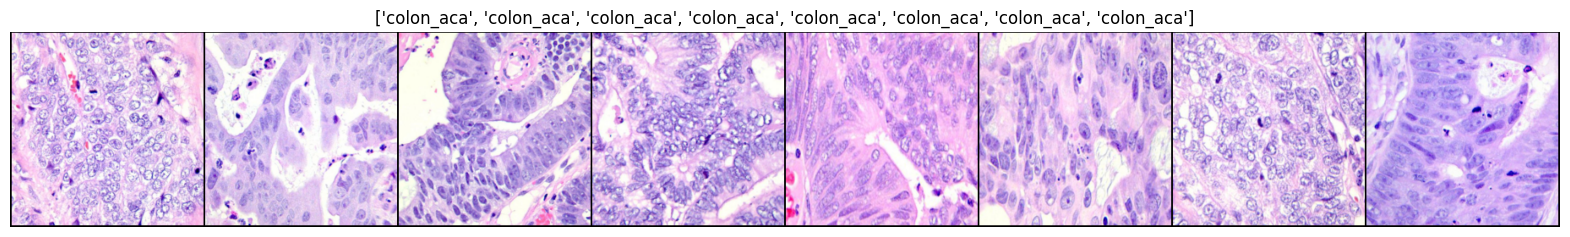

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[imageDatasetTrain.classes[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(TRAIN))
show_databatch(inputs, classes)

In [ ]:
sharpenedTrain = datasets.ImageFolder(
    "/kaggle/working/trainDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.RandomAdjustSharpness(5, p=1), #increasing the sharpness of borders of the image
              transforms.ToTensor()])
)
sharpenedVal = datasets.ImageFolder(
    "/kaggle/working/valDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.RandomAdjustSharpness(5, p=1),
              transforms.ToTensor()])
)
TRAIN = torch.utils.data.DataLoader(sharpenedTrain, batch_size=32, shuffle=True)
VAL = torch.utils.data.DataLoader(sharpenedVal, batch_size=32, shuffle=True)

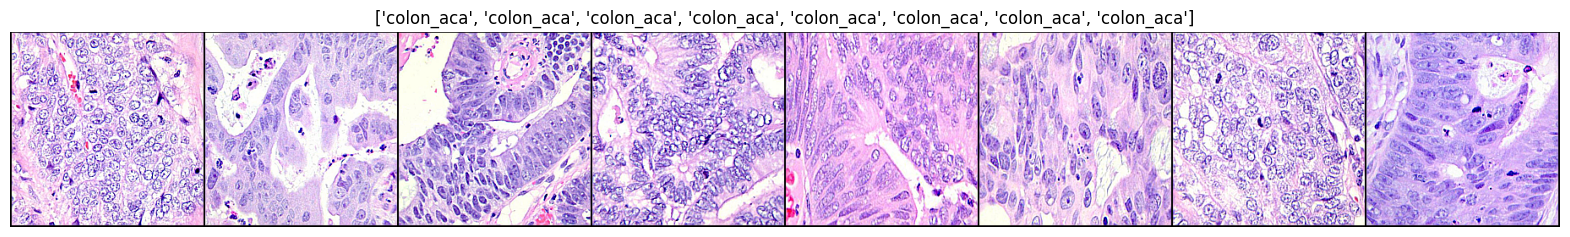

In [ ]:
inputs, classes = next(iter(TRAIN))
show_databatch(inputs, classes)

This preprocessing step greatly enhanced the borders of the image, as can be seen clearly in the 3rd and 4th images. 

## Data Augmentation

In [ ]:
augTrain = datasets.ImageFolder(
    "/kaggle/working/trainDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.RandomPerspective(),
              transforms.ToTensor()])
)
augVal = datasets.ImageFolder(
    "/kaggle/working/valDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.RandomPerspective(),
              transforms.ToTensor()])
)
TRAIN = torch.utils.data.DataLoader(augTrain, batch_size=8)
VAL = torch.utils.data.DataLoader(augVal, batch_size=8)

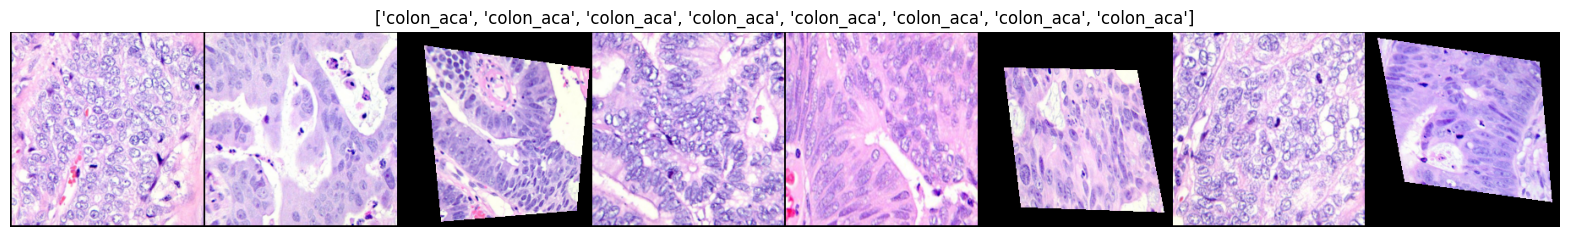

In [ ]:
inputs, classes = next(iter(TRAIN))
show_databatch(inputs, classes)

This preprocessing step augments data by flipping horizontally/vertically, and performs perspective transformation.

In [ ]:
blurTrain = datasets.ImageFolder(
    "/kaggle/working/trainDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.GaussianBlur(5), #blurring the image
              transforms.ToTensor()])
)
blurVal = datasets.ImageFolder(
    "/kaggle/working/valDir",
    transform = transforms.Compose([
              transforms.Resize(227),
              transforms.GaussianBlur(5),
              transforms.ToTensor()])
)
TRAIN = torch.utils.data.DataLoader(blurTrain, batch_size=8)
VAL = torch.utils.data.DataLoader(blurVal, batch_size=8)

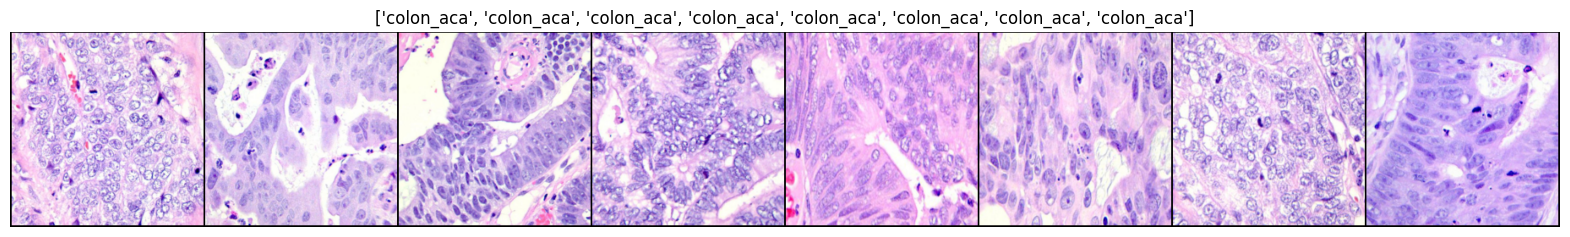

In [ ]:
inputs, classes = next(iter(TRAIN))
show_databatch(inputs, classes)

## Training Models

In [ ]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(TRAIN)
    val_batches = len(VAL)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for i, data in enumerate(TRAIN):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / 20000
        avg_acc = acc_train * 2 / 20000
        
        model.train(False)
        model.eval()
            
        for i, data in enumerate(VAL):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data.item()
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / 5000
        avg_acc_val = acc_val / 5000
        
        print()
        print("Epoch {} result: ".format(epoch+1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

# Transfer Learning

## AlexNet with Preprocessing

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def results(val, model, train):
    predictions = []
    actual=[]
    for X, y in val:
        if use_gpu:
            X = X.cuda()
        outputs = model(X)
        _, preds = torch.max(outputs.data, 1)
        predictions.extend([int(x) for x in preds])
        actual.extend([int(x) for x in y])
    print(classification_report(actual,predictions))
    print("\n\n")
    cm = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train.classes)
    disp.plot()
    plt.show()

In [ ]:
alex = models.alexnet(weights='DEFAULT')

featureList = list(alex.features.children())

for param in featureList[1:]:
    param.require_grad = False

alex.features = nn.Sequential(*featureList)

alex.classifier[6].out_features = 5

print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
if use_gpu:
    alex.cuda()
n_epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex.parameters(), lr=0.00001, momentum=0.9)
alex = train_model(alex, loss_fn, optimizer, num_epochs=n_epochs)
torch.save(alex.state_dict(), 'ANSharpening')

Epoch 1/30
----------
Validation batch 100/157
Epoch 1 result: 
Avg loss (train): 0.0531
Avg acc (train): 0.5934
Avg loss (val): 0.0103
Avg acc (val): 0.8898
----------

Epoch 2/30
----------
Validation batch 100/157
Epoch 2 result: 
Avg loss (train): 0.0120
Avg acc (train): 0.8561
Avg loss (val): 0.0067
Avg acc (val): 0.9242
----------

Epoch 3/30
----------
Validation batch 100/157
Epoch 3 result: 
Avg loss (train): 0.0091
Avg acc (train): 0.8924
Avg loss (val): 0.0054
Avg acc (val): 0.9358
----------

Epoch 4/30
----------
Validation batch 100/157
Epoch 4 result: 
Avg loss (train): 0.0077
Avg acc (train): 0.9059
Avg loss (val): 0.0049
Avg acc (val): 0.9436
----------

Epoch 5/30
----------
Validation batch 100/157
Epoch 5 result: 
Avg loss (train): 0.0066
Avg acc (train): 0.9206
Avg loss (val): 0.0044
Avg acc (val): 0.9486
----------

Epoch 6/30
----------
Validation batch 100/157
Epoch 6 result: 
Avg loss (train): 0.0062
Avg acc (train): 0.9270
Avg loss (val): 0.0041
Avg acc (val):

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1000
           1       0.99      0.99      0.99      1000
           2       0.95      0.96      0.96      1000
           3       0.99      1.00      0.99      1000
           4       0.97      0.95      0.96      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000






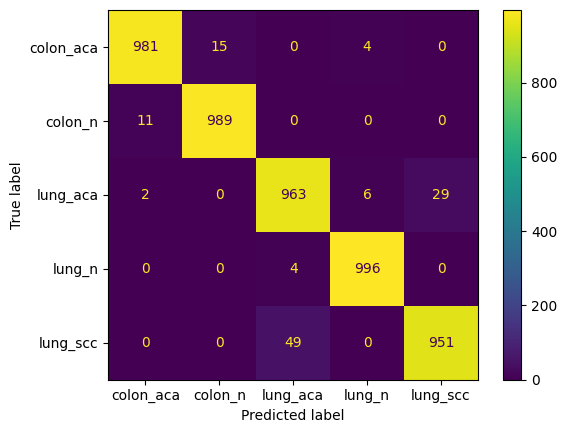

In [ ]:
results(VAL, alex, sharpenedTrain)

The accuracy for 30 epochs on an Alexnet model with image sharpening is 98%. While the recall for most of the classes is good, it is less for two of the classes - `lung_aca` and `lung_scc`. Perhaps it may improve on training for more epochs.

## Transfer Learning (Paper Implementation using AlexNet)

In the paper, the authors have also used AlexNet, wherein they initially did not use any image processing. They just ran the model and got an accuracy of 89%. However, on trying to reproduce the same paper, we got an accuracy of 98%. They further tried to improve the model by selective image processing of the class which had the least recall (this part has not been implemented yet).  

In [ ]:
if use_gpu:
    alex.cuda()
n_epochs = 60
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex.parameters(), lr=0.00001, momentum=0.9)
alex = train_model(alex, loss_fn, optimizer, num_epochs=n_epochs)
torch.save(alex.state_dict(), 'AlexNetWithVal')

Epoch 1/60
----------
Validation batch 100/157
Epoch 1 result: 
Avg loss (train): 0.0544
Avg acc (train): 0.5638
Avg loss (val): 0.0117
Avg acc (val): 0.8744
----------

Epoch 2/60
----------
Validation batch 100/157
Epoch 2 result: 
Avg loss (train): 0.0132
Avg acc (train): 0.8345
Avg loss (val): 0.0075
Avg acc (val): 0.9128
----------

Epoch 3/60
----------
Validation batch 100/157
Epoch 3 result: 
Avg loss (train): 0.0095
Avg acc (train): 0.8846
Avg loss (val): 0.0058
Avg acc (val): 0.9338
----------

Epoch 4/60
----------
Validation batch 100/157
Epoch 4 result: 
Avg loss (train): 0.0078
Avg acc (train): 0.9045
Avg loss (val): 0.0047
Avg acc (val): 0.9468
----------

Epoch 5/60
----------
Validation batch 100/157
Epoch 5 result: 
Avg loss (train): 0.0069
Avg acc (train): 0.9164
Avg loss (val): 0.0044
Avg acc (val): 0.9490
----------

Epoch 6/60
----------
Validation batch 100/157
Epoch 6 result: 
Avg loss (train): 0.0062
Avg acc (train): 0.9256
Avg loss (val): 0.0047
Avg acc (val):

In [ ]:
from sklearn.metrics import classification_report
predictions = []
actual=[]
for X, y in VAL:
    X = X.cuda()
    outputs = alex(X)
    _, preds = torch.max(outputs.data, 1)
    predictions.extend([int(x) for x in preds])
    actual.extend([int(x) for x in y])
print(classification_report(actual,predictions))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      1.00      1.00      1000
           2       0.95      0.97      0.96      1000
           3       1.00      0.99      1.00      1000
           4       0.97      0.96      0.97      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predictions)

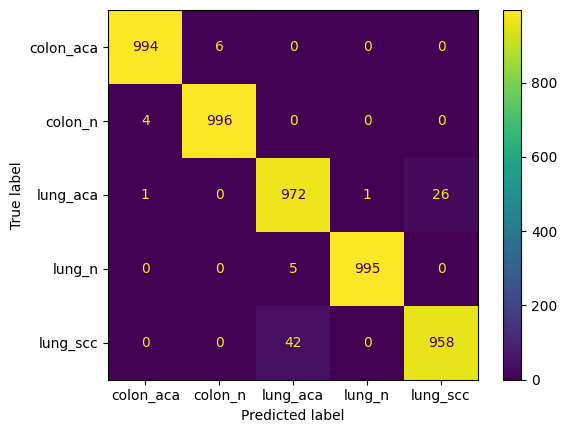

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=imageDatasetTrain.classes)
disp.plot()
plt.show()